Processing Excel files...

Processing: DiD_BCF_GATE_PS_and_PValues_linearity=1.xlsx (as 'DiD_BCF')
  Collected 900 P-values. Significant count: 900. Frequency: 1.0000
Processing: did_dr_GATE_PS_and_PValues_linearity_degree=1.xlsx (as 'did_dr')
  Collected 900 P-values. Significant count: 846. Frequency: 0.9400
Processing: DoubleML_did_GATE_PS_and_PValues_linearity_degree=1.xlsx (as 'DoubleML_did')
  Collected 896 P-values. Significant count: 174. Frequency: 0.1942
Processing: OLS_GATE_PS_and_PValues_linearity=1.xlsx (as 'OLS')
  Collected 900 P-values. Significant count: 900. Frequency: 1.0000
Processing: synthdid_GATE_PS_and_PValues_linearity_degree=1.xlsx (as 'synthdid')
  Collected 900 P-values. Significant count: 900. Frequency: 1.0000

--- Processing Complete ---

Overall Significance Frequency Table:
              Overall Significance Frequency (P <= 0.05)
DiD_BCF                                         1.000000
did_dr                                          0.940000
DoubleML_di

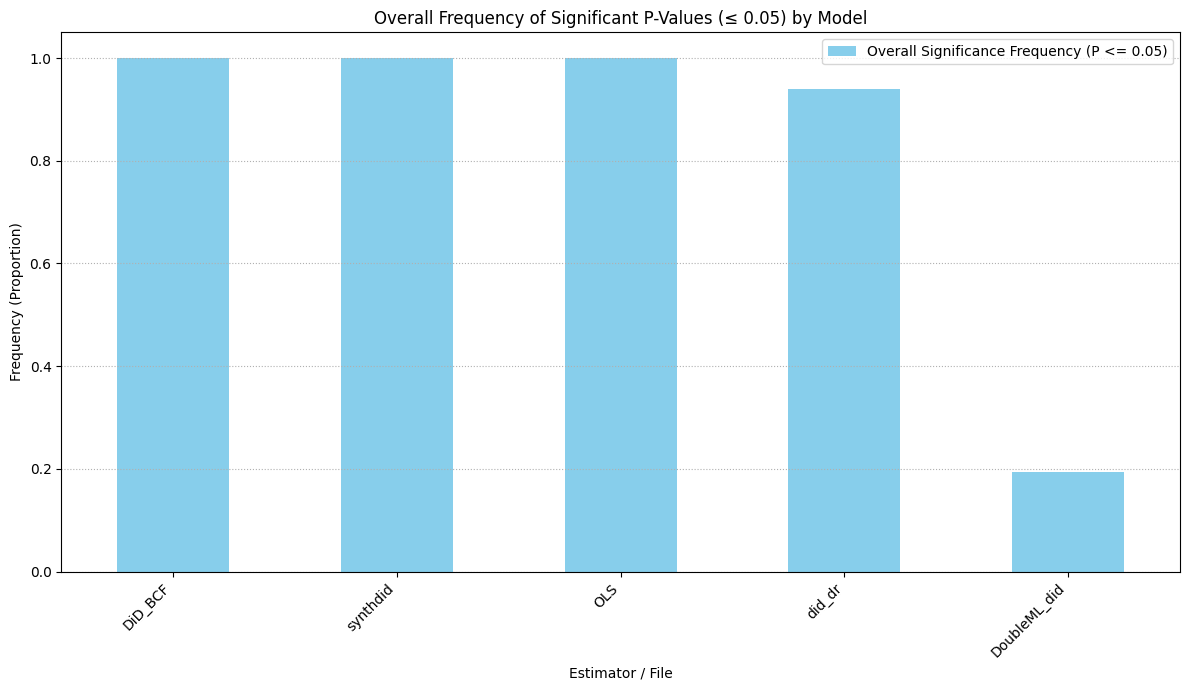

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 0. Define file names and configurations
excel_files = [
    "DiD_BCF_GATE_PS_and_PValues_linearity=1.xlsx",
    "did_dr_GATE_PS_and_PValues_linearity_degree=1.xlsx",
    "DoubleML_did_GATE_PS_and_PValues_linearity_degree=1.xlsx",
    "OLS_GATE_PS_and_PValues_linearity=1.xlsx",
    "synthdid_GATE_PS_and_PValues_linearity_degree=1.xlsx"
]

# Files needing P-value transformation and have specific (capitalized) sheet names & column set 1
transform_and_config_A_files = [
    "DiD_BCF_GATE_PS_and_PValues_linearity=1.xlsx",
    "OLS_GATE_PS_and_PValues_linearity=1.xlsx"
]

# Configuration for DiD_BCF and OLS files
config_A = {
    "sheet_names_map": {"s0": "Group_0", "s1": "Group_1", "s2": "Group_2"}, # Abstracted keys
    "column_indices": { # 0-based indices
        "Group_0": [3, 4, 5, 6], # 4th, 5th, 6th, 7th
        "Group_1": [4, 5, 6],    # 5th, 6th, 7th
        "Group_2": [5, 6]        # 6th, 7th
    },
    "transform_pvalues": True
}

# Configuration for other files
config_B = {
    "sheet_names_map": {"s0": "group_0", "s1": "group_1", "s2": "group_2"}, # Abstracted keys
    "column_indices": { # 0-based indices
        "group_0": [0, 1, 2, 3], # 1st, 2nd, 3rd, 4th
        "group_1": [1, 2, 3],    # 2nd, 3rd, 4th
        "group_2": [2, 3]        # 3rd, 4th
    },
    "transform_pvalues": False
}

# Dictionary to store overall frequency results
overall_frequency_data = {}

# --- Helper function to create cleaner names for display ---
def get_clean_filename(filepath):
    base = os.path.basename(filepath)
    name = base
    # Define specific suffixes to remove first
    suffixes_to_remove = [
        "_GATE_PS_and_PValues_linearity=1.xlsx",
        "_GATE_PS_and_PValues_linearity_degree=1.xlsx",
    ]
    for suffix in suffixes_to_remove:
        if name.endswith(suffix):
            name = name[:-len(suffix)]
            break
    # Generic cleanup for remaining parts if any
    name = name.replace('_linearity=1', '')
    name = name.replace('_linearity_degree=1', '')
    name = name.replace('.xlsx', '')
    return name

print("Processing Excel files...\n")
# Ensure you have openpyxl installed: pip install openpyxl

for file_path in excel_files:
    clean_name = get_clean_filename(file_path)
    print(f"Processing: {file_path} (as '{clean_name}')")

    current_config = config_A if file_path in transform_and_config_A_files else config_B
    
    all_p_values_for_file = [] # To collect all P-values from relevant sheets/columns

    # Iterate through the logical sheet groups (s0, s1, s2)
    for sheet_key in current_config["sheet_names_map"].keys(): # e.g., "s0", "s1", "s2"
        actual_sheet_name = current_config["sheet_names_map"][sheet_key]
        
        try:
            # Read the specific sheet. Assuming P-values start from the first row, no specific header row for data.
            df_sheet = pd.read_excel(file_path, sheet_name=actual_sheet_name, header=None)
        except FileNotFoundError:
            print(f"Error: File not found - {file_path}")
            break # Stop processing this file if the workbook itself is missing
        except ValueError as ve: # Specific error for missing sheet in openpyxl
             if f"Worksheet {actual_sheet_name} not found" in str(ve) or "No sheet named" in str(ve) : # Check specific error message
                print(f"Warning: Sheet '{actual_sheet_name}' not found in '{file_path}'. Skipping this sheet.")
                continue
             else: # Other ValueError
                print(f"An error occurred reading sheet '{actual_sheet_name}' from '{file_path}': {ve}")
                continue
        except Exception as e:
            print(f"An unexpected error occurred reading sheet '{actual_sheet_name}' from '{file_path}': {e}")
            continue

        cols_to_extract_indices = current_config["column_indices"].get(actual_sheet_name, [])
        
        if not df_sheet.empty:
            for col_idx in cols_to_extract_indices:
                if col_idx < df_sheet.shape[1]: # Check column index is within bounds
                    # Extract the column, convert to numeric, drop NaNs
                    p_vals_series = pd.to_numeric(df_sheet.iloc[:, col_idx], errors='coerce').dropna()
                    if not p_vals_series.empty:
                        all_p_values_for_file.extend(p_vals_series.tolist())
                else:
                    print(f"Warning: Column index {col_idx} is out of bounds for sheet '{actual_sheet_name}' (max index {df_sheet.shape[1]-1}) in {file_path}. Skipping this column.")
        else:
            print(f"Warning: Sheet '{actual_sheet_name}' in {file_path} is empty. Skipping.")
            
    if not all_p_values_for_file:
        print(f"Warning: No valid P-values collected for {file_path}. Setting frequency to 0.0.")
        overall_frequency_data[clean_name] = 0.0
        continue

    p_series = pd.Series(all_p_values_for_file)
    
    significant_count = 0
    total_valid_pvalues = len(p_series) # p_series already has NaNs dropped

    if total_valid_pvalues == 0: # Should be caught by the "if not all_p_values_for_file"
        overall_frequency_data[clean_name] = 0.0
        continue

    if current_config["transform_pvalues"]:
        # Transform P-values: 0 if value > 0.05, 1 otherwise (<= 0.05 or NaN - NaNs already dropped)
        transformed_p_series = p_series.apply(lambda x: 0 if x > 0.05 else 1)
        significant_count = (transformed_p_series == 1).sum()
    else:
        # Count P-values <= 0.05 directly
        significant_count = (p_series == 1).sum()
        
    frequency = significant_count / total_valid_pvalues
    overall_frequency_data[clean_name] = frequency
    print(f"  Collected {total_valid_pvalues} P-values. Significant count: {significant_count}. Frequency: {frequency:.4f}")


print("\n--- Processing Complete ---\n")

# Create a table and graph of overall frequencies
if overall_frequency_data:
    # Create a Pandas Series from the dictionary for easier plotting and table display
    frequency_series_1 = pd.Series(overall_frequency_data)
    frequency_series_1.name = "Overall Significance Frequency (P <= 0.05)" # Name for the series/column

    # Create a DataFrame for printing the table
    frequency_df_table_1 = frequency_series_1.to_frame()

    print("Overall Significance Frequency Table:")
    print(frequency_df_table_1)
    print("\n")

    # Create the graph
    fig, ax = plt.subplots(figsize=(12, 7)) # Adjusted figure size
    frequency_series_1.sort_values(ascending=False).plot(kind='bar', ax=ax, color='skyblue') # Sort for better viz
    ax.set_title('Overall Frequency of Significant P-Values (≤ 0.05) by Model')
    ax.set_ylabel('Frequency (Proportion)')
    ax.set_xlabel('Estimator / File')
    plt.xticks(rotation=45, ha='right')
    ax.legend() # This will show the legend for the axhline
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout()
    plt.show()
else:
    print("No data was processed to create a table or graph.")

Processing Excel files...

Processing: DiD_BCF_GATE_PS_and_PValues_linearity=2.xlsx (as 'DiD_BCF')
  Collected 900 P-values. Significant count: 891. Frequency: 0.9900
Processing: did_dr_GATE_PS_and_PValues_linearity_degree=2.xlsx (as 'did_dr')
  Collected 900 P-values. Significant count: 176. Frequency: 0.1956
Processing: DoubleML_did_GATE_PS_and_PValues_linearity_degree=2.xlsx (as 'DoubleML_did')
  Collected 896 P-values. Significant count: 21. Frequency: 0.0234
Processing: OLS_GATE_PS_and_PValues_linearity=2.xlsx (as 'OLS')
  Collected 900 P-values. Significant count: 498. Frequency: 0.5533
Processing: synthdid_GATE_PS_and_PValues_linearity_degree=2.xlsx (as 'synthdid')
  Collected 900 P-values. Significant count: 477. Frequency: 0.5300

--- Processing Complete ---

Overall Significance Frequency Table:
              Overall Significance Frequency (P <= 0.05)
DiD_BCF                                         0.990000
did_dr                                          0.195556
DoubleML_did

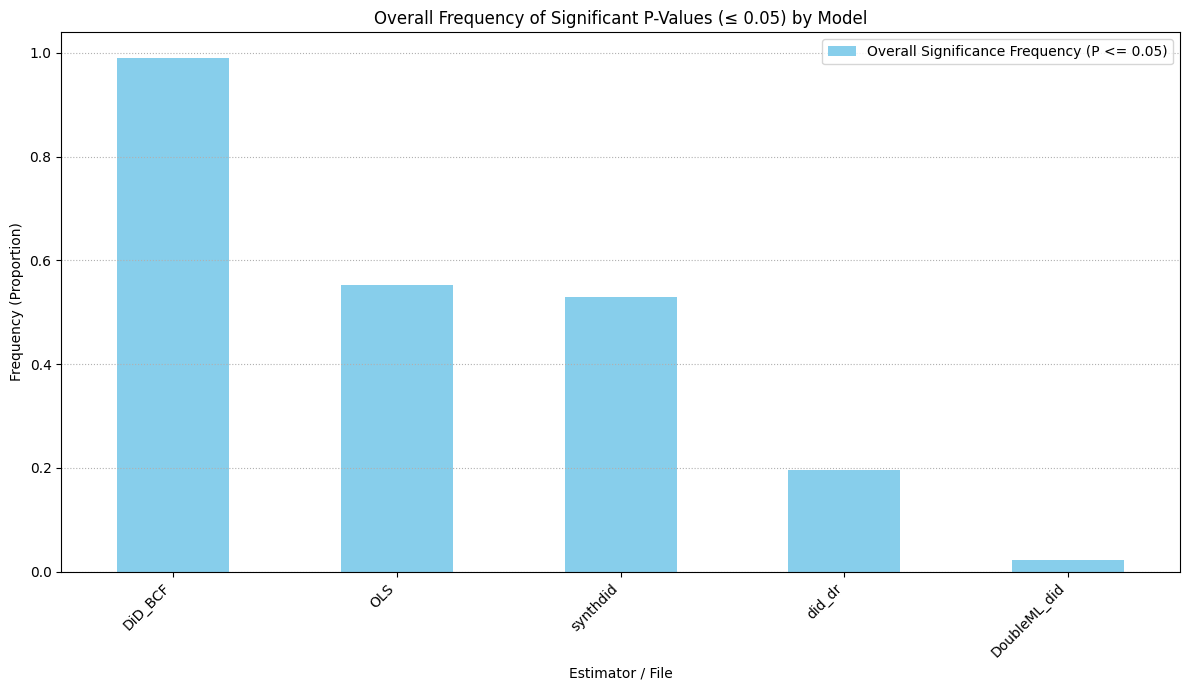

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 0. Define file names and configurations
excel_files = [
    "DiD_BCF_GATE_PS_and_PValues_linearity=2.xlsx",
    "did_dr_GATE_PS_and_PValues_linearity_degree=2.xlsx",
    "DoubleML_did_GATE_PS_and_PValues_linearity_degree=2.xlsx",
    "OLS_GATE_PS_and_PValues_linearity=2.xlsx",
    "synthdid_GATE_PS_and_PValues_linearity_degree=2.xlsx"
]

# Files needing P-value transformation and have specific (capitalized) sheet names & column set 1
transform_and_config_A_files = [
    "DiD_BCF_GATE_PS_and_PValues_linearity=2.xlsx",
    "OLS_GATE_PS_and_PValues_linearity=2.xlsx"
]

# Configuration for DiD_BCF and OLS files
config_A = {
    "sheet_names_map": {"s0": "Group_0", "s1": "Group_1", "s2": "Group_2"}, # Abstracted keys
    "column_indices": { # 0-based indices
        "Group_0": [3, 4, 5, 6], # 4th, 5th, 6th, 7th
        "Group_1": [4, 5, 6],    # 5th, 6th, 7th
        "Group_2": [5, 6]        # 6th, 7th
    },
    "transform_pvalues": True
}

# Configuration for other files
config_B = {
    "sheet_names_map": {"s0": "group_0", "s1": "group_1", "s2": "group_2"}, # Abstracted keys
    "column_indices": { # 0-based indices
        "group_0": [0, 1, 2, 3], # 1st, 2nd, 3rd, 4th
        "group_1": [1, 2, 3],    # 2nd, 3rd, 4th
        "group_2": [2, 3]        # 3rd, 4th
    },
    "transform_pvalues": False
}

# Dictionary to store overall frequency results
overall_frequency_data = {}

# --- Helper function to create cleaner names for display ---
def get_clean_filename(filepath):
    base = os.path.basename(filepath)
    name = base
    # Define specific suffixes to remove first
    suffixes_to_remove = [
        "_GATE_PS_and_PValues_linearity=2.xlsx",
        "_GATE_PS_and_PValues_linearity_degree=2.xlsx",
    ]
    for suffix in suffixes_to_remove:
        if name.endswith(suffix):
            name = name[:-len(suffix)]
            break
    # Generic cleanup for remaining parts if any
    name = name.replace('_linearity=2', '')
    name = name.replace('_linearity_degree=2', '')
    name = name.replace('.xlsx', '')
    return name

print("Processing Excel files...\n")
# Ensure you have openpyxl installed: pip install openpyxl

for file_path in excel_files:
    clean_name = get_clean_filename(file_path)
    print(f"Processing: {file_path} (as '{clean_name}')")

    current_config = config_A if file_path in transform_and_config_A_files else config_B
    
    all_p_values_for_file = [] # To collect all P-values from relevant sheets/columns

    # Iterate through the logical sheet groups (s0, s1, s2)
    for sheet_key in current_config["sheet_names_map"].keys(): # e.g., "s0", "s1", "s2"
        actual_sheet_name = current_config["sheet_names_map"][sheet_key]
        
        try:
            # Read the specific sheet. Assuming P-values start from the first row, no specific header row for data.
            df_sheet = pd.read_excel(file_path, sheet_name=actual_sheet_name, header=None)
        except FileNotFoundError:
            print(f"Error: File not found - {file_path}")
            break # Stop processing this file if the workbook itself is missing
        except ValueError as ve: # Specific error for missing sheet in openpyxl
             if f"Worksheet {actual_sheet_name} not found" in str(ve) or "No sheet named" in str(ve) : # Check specific error message
                print(f"Warning: Sheet '{actual_sheet_name}' not found in '{file_path}'. Skipping this sheet.")
                continue
             else: # Other ValueError
                print(f"An error occurred reading sheet '{actual_sheet_name}' from '{file_path}': {ve}")
                continue
        except Exception as e:
            print(f"An unexpected error occurred reading sheet '{actual_sheet_name}' from '{file_path}': {e}")
            continue

        cols_to_extract_indices = current_config["column_indices"].get(actual_sheet_name, [])
        
        if not df_sheet.empty:
            for col_idx in cols_to_extract_indices:
                if col_idx < df_sheet.shape[1]: # Check column index is within bounds
                    # Extract the column, convert to numeric, drop NaNs
                    p_vals_series = pd.to_numeric(df_sheet.iloc[:, col_idx], errors='coerce').dropna()
                    if not p_vals_series.empty:
                        all_p_values_for_file.extend(p_vals_series.tolist())
                else:
                    print(f"Warning: Column index {col_idx} is out of bounds for sheet '{actual_sheet_name}' (max index {df_sheet.shape[1]-1}) in {file_path}. Skipping this column.")
        else:
            print(f"Warning: Sheet '{actual_sheet_name}' in {file_path} is empty. Skipping.")
            
    if not all_p_values_for_file:
        print(f"Warning: No valid P-values collected for {file_path}. Setting frequency to 0.0.")
        overall_frequency_data[clean_name] = 0.0
        continue

    p_series = pd.Series(all_p_values_for_file)
    
    significant_count = 0
    total_valid_pvalues = len(p_series) # p_series already has NaNs dropped

    if total_valid_pvalues == 0: # Should be caught by the "if not all_p_values_for_file"
        overall_frequency_data[clean_name] = 0.0
        continue

    if current_config["transform_pvalues"]:
        # Transform P-values: 0 if value > 0.05, 1 otherwise (<= 0.05 or NaN - NaNs already dropped)
        transformed_p_series = p_series.apply(lambda x: 0 if x > 0.05 else 1)
        significant_count = (transformed_p_series == 1).sum()
    else:
        # Count P-values <= 0.05 directly
        significant_count = (p_series == 1).sum()
        
    frequency = significant_count / total_valid_pvalues
    overall_frequency_data[clean_name] = frequency
    print(f"  Collected {total_valid_pvalues} P-values. Significant count: {significant_count}. Frequency: {frequency:.4f}")


print("\n--- Processing Complete ---\n")

# Create a table and graph of overall frequencies
if overall_frequency_data:
    # Create a Pandas Series from the dictionary for easier plotting and table display
    frequency_series_2 = pd.Series(overall_frequency_data)
    frequency_series_2.name = "Overall Significance Frequency (P <= 0.05)" # Name for the series/column

    # Create a DataFrame for printing the table
    frequency_df_table_2 = frequency_series_2.to_frame()

    print("Overall Significance Frequency Table:")
    print(frequency_df_table_2)
    print("\n")

    # Create the graph
    fig, ax = plt.subplots(figsize=(12, 7)) # Adjusted figure size
    frequency_series_2.sort_values(ascending=False).plot(kind='bar', ax=ax, color='skyblue') # Sort for better viz
    ax.set_title('Overall Frequency of Significant P-Values (≤ 0.05) by Model')
    ax.set_ylabel('Frequency (Proportion)')
    ax.set_xlabel('Estimator / File')
    plt.xticks(rotation=45, ha='right')
    ax.legend() # This will show the legend for the axhline
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout()
    plt.show()
else:
    print("No data was processed to create a table or graph.")

Processing Excel files...

Processing: DiD_BCF_GATE_PS_and_PValues_linearity=3.xlsx (as 'DiD_BCF')
  Collected 900 P-values. Significant count: 897. Frequency: 0.9967
Processing: did_dr_GATE_PS_and_PValues_linearity_degree=3.xlsx (as 'did_dr')
  Collected 900 P-values. Significant count: 290. Frequency: 0.3222
Processing: DoubleML_did_GATE_PS_and_PValues_linearity_degree=3.xlsx (as 'DoubleML_did')
  Collected 896 P-values. Significant count: 47. Frequency: 0.0525
Processing: OLS_GATE_PS_and_PValues_linearity=3.xlsx (as 'OLS')
  Collected 900 P-values. Significant count: 620. Frequency: 0.6889
Processing: synthdid_GATE_PS_and_PValues_linearity_degree=3.xlsx (as 'synthdid')
  Collected 900 P-values. Significant count: 846. Frequency: 0.9400

--- Processing Complete ---

Overall Significance Frequency Table:
              Overall Significance Frequency (P <= 0.05)
DiD_BCF                                         0.996667
did_dr                                          0.322222
DoubleML_did

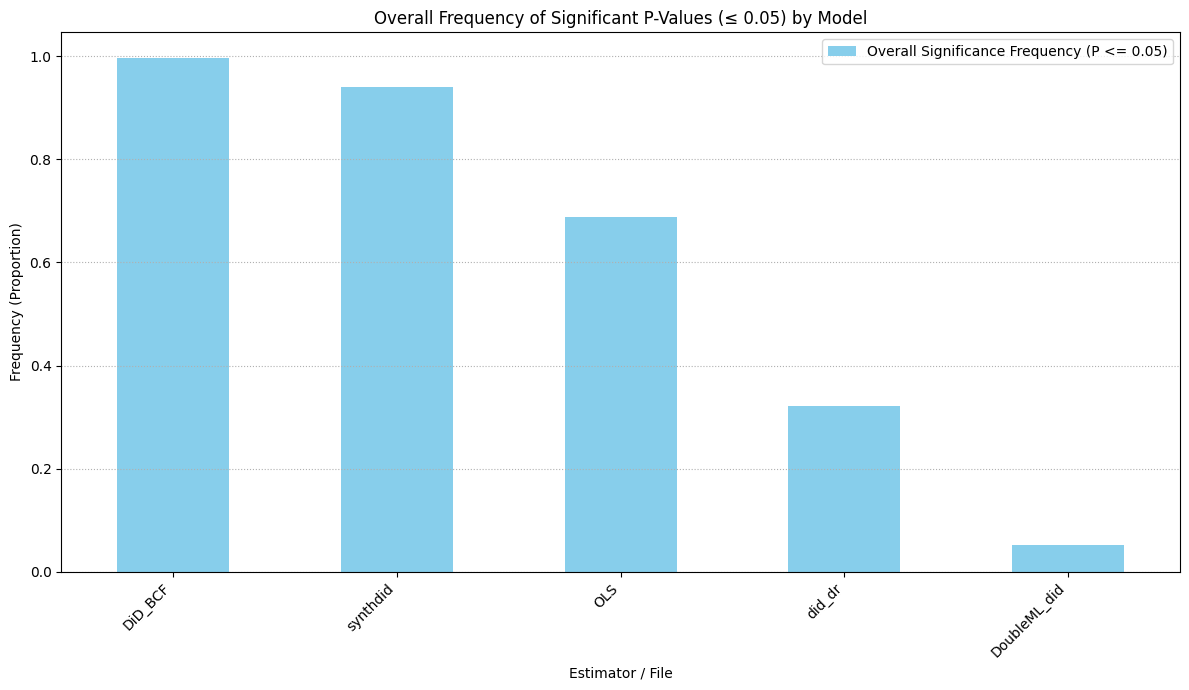

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 0. Define file names and configurations
excel_files = [
    "DiD_BCF_GATE_PS_and_PValues_linearity=3.xlsx",
    "did_dr_GATE_PS_and_PValues_linearity_degree=3.xlsx",
    "DoubleML_did_GATE_PS_and_PValues_linearity_degree=3.xlsx",
    "OLS_GATE_PS_and_PValues_linearity=3.xlsx",
    "synthdid_GATE_PS_and_PValues_linearity_degree=3.xlsx"
]

# Files needing P-value transformation and have specific (capitalized) sheet names & column set 1
transform_and_config_A_files = [
    "DiD_BCF_GATE_PS_and_PValues_linearity=3.xlsx",
    "OLS_GATE_PS_and_PValues_linearity=3.xlsx"
]

# Configuration for DiD_BCF and OLS files
config_A = {
    "sheet_names_map": {"s0": "Group_0", "s1": "Group_1", "s2": "Group_2"}, # Abstracted keys
    "column_indices": { # 0-based indices
        "Group_0": [3, 4, 5, 6], # 4th, 5th, 6th, 7th
        "Group_1": [4, 5, 6],    # 5th, 6th, 7th
        "Group_2": [5, 6]        # 6th, 7th
    },
    "transform_pvalues": True
}

# Configuration for other files
config_B = {
    "sheet_names_map": {"s0": "group_0", "s1": "group_1", "s2": "group_2"}, # Abstracted keys
    "column_indices": { # 0-based indices
        "group_0": [0, 1, 2, 3], # 1st, 2nd, 3rd, 4th
        "group_1": [1, 2, 3],    # 2nd, 3rd, 4th
        "group_2": [2, 3]        # 3rd, 4th
    },
    "transform_pvalues": False
}

# Dictionary to store overall frequency results
overall_frequency_data = {}

# --- Helper function to create cleaner names for display ---
def get_clean_filename(filepath):
    base = os.path.basename(filepath)
    name = base
    # Define specific suffixes to remove first
    suffixes_to_remove = [
        "_GATE_PS_and_PValues_linearity=3.xlsx",
        "_GATE_PS_and_PValues_linearity_degree=3.xlsx",
    ]
    for suffix in suffixes_to_remove:
        if name.endswith(suffix):
            name = name[:-len(suffix)]
            break
    # Generic cleanup for remaining parts if any
    name = name.replace('_linearity=3', '')
    name = name.replace('_linearity_degree=3', '')
    name = name.replace('.xlsx', '')
    return name

print("Processing Excel files...\n")
# Ensure you have openpyxl installed: pip install openpyxl

for file_path in excel_files:
    clean_name = get_clean_filename(file_path)
    print(f"Processing: {file_path} (as '{clean_name}')")

    current_config = config_A if file_path in transform_and_config_A_files else config_B
    
    all_p_values_for_file = [] # To collect all P-values from relevant sheets/columns

    # Iterate through the logical sheet groups (s0, s1, s2)
    for sheet_key in current_config["sheet_names_map"].keys(): # e.g., "s0", "s1", "s2"
        actual_sheet_name = current_config["sheet_names_map"][sheet_key]
        
        try:
            # Read the specific sheet. Assuming P-values start from the first row, no specific header row for data.
            df_sheet = pd.read_excel(file_path, sheet_name=actual_sheet_name, header=None)
        except FileNotFoundError:
            print(f"Error: File not found - {file_path}")
            break # Stop processing this file if the workbook itself is missing
        except ValueError as ve: # Specific error for missing sheet in openpyxl
             if f"Worksheet {actual_sheet_name} not found" in str(ve) or "No sheet named" in str(ve) : # Check specific error message
                print(f"Warning: Sheet '{actual_sheet_name}' not found in '{file_path}'. Skipping this sheet.")
                continue
             else: # Other ValueError
                print(f"An error occurred reading sheet '{actual_sheet_name}' from '{file_path}': {ve}")
                continue
        except Exception as e:
            print(f"An unexpected error occurred reading sheet '{actual_sheet_name}' from '{file_path}': {e}")
            continue

        cols_to_extract_indices = current_config["column_indices"].get(actual_sheet_name, [])
        
        if not df_sheet.empty:
            for col_idx in cols_to_extract_indices:
                if col_idx < df_sheet.shape[1]: # Check column index is within bounds
                    # Extract the column, convert to numeric, drop NaNs
                    p_vals_series = pd.to_numeric(df_sheet.iloc[:, col_idx], errors='coerce').dropna()
                    if not p_vals_series.empty:
                        all_p_values_for_file.extend(p_vals_series.tolist())
                else:
                    print(f"Warning: Column index {col_idx} is out of bounds for sheet '{actual_sheet_name}' (max index {df_sheet.shape[1]-1}) in {file_path}. Skipping this column.")
        else:
            print(f"Warning: Sheet '{actual_sheet_name}' in {file_path} is empty. Skipping.")
            
    if not all_p_values_for_file:
        print(f"Warning: No valid P-values collected for {file_path}. Setting frequency to 0.0.")
        overall_frequency_data[clean_name] = 0.0
        continue

    p_series = pd.Series(all_p_values_for_file)
    
    significant_count = 0
    total_valid_pvalues = len(p_series) # p_series already has NaNs dropped

    if total_valid_pvalues == 0: # Should be caught by the "if not all_p_values_for_file"
        overall_frequency_data[clean_name] = 0.0
        continue

    if current_config["transform_pvalues"]:
        # Transform P-values: 0 if value > 0.05, 1 otherwise (<= 0.05 or NaN - NaNs already dropped)
        transformed_p_series = p_series.apply(lambda x: 0 if x > 0.05 else 1)
        significant_count = (transformed_p_series == 1).sum()
    else:
        # Count P-values <= 0.05 directly
        significant_count = (p_series == 1).sum()
        
    frequency = significant_count / total_valid_pvalues
    overall_frequency_data[clean_name] = frequency
    print(f"  Collected {total_valid_pvalues} P-values. Significant count: {significant_count}. Frequency: {frequency:.4f}")


print("\n--- Processing Complete ---\n")

# Create a table and graph of overall frequencies
if overall_frequency_data:
    # Create a Pandas Series from the dictionary for easier plotting and table display
    frequency_series_3 = pd.Series(overall_frequency_data)
    frequency_series_3.name = "Overall Significance Frequency (P <= 0.05)" # Name for the series/column

    # Create a DataFrame for printing the table
    frequency_df_table_3 = frequency_series_3.to_frame()

    print("Overall Significance Frequency Table:")
    print(frequency_df_table_3)
    print("\n")

    # Create the graph
    fig, ax = plt.subplots(figsize=(12, 7)) # Adjusted figure size
    frequency_series_3.sort_values(ascending=False).plot(kind='bar', ax=ax, color='skyblue') # Sort for better viz
    ax.set_title('Overall Frequency of Significant P-Values (≤ 0.05) by Model')
    ax.set_ylabel('Frequency (Proportion)')
    ax.set_xlabel('Estimator / File')
    plt.xticks(rotation=45, ha='right')
    ax.legend() # This will show the legend for the axhline
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout()
    plt.show()
else:
    print("No data was processed to create a table or graph.")

In [4]:
def merge_frequency_tables(df1, df2, df3):
    """
    Merges three pandas DataFrames, assuming they have the same index
    (method names) and creates new columns named Setting 1, Setting 2, and Setting 3.

    Args:
        df1: First DataFrame.  Method names as the index.
        df2: Second DataFrame. Method names as the index.
        df3: Third DataFrame. Method names as the index.

    Returns:
        A merged DataFrame, or None if input is invalid or merging fails.
    """
    if not all(isinstance(df, pd.DataFrame) for df in [df1, df2, df3]):
        print("Error: All inputs must be pandas DataFrames.")
        return None

    try:
        # Ensure the index (method names) are the same across all dataframes
        if not all(df.index.equals(df1.index) for df in [df2, df3]):
            print("Error: DataFrames must have the same index (method names).")
            return None

        # Merge the dataframes horizontally
        merged_df = pd.concat([df1, df2, df3], axis=1)

        return merged_df

    except Exception as e:
        print(f"An error occurred during merging: {e}")
        return None


frequency_df= merge_frequency_tables(frequency_df_table_1, frequency_df_table_2, frequency_df_table_3)
frequency_df.columns=["Setting 1","Setting 2","Setting 3"]

Frequency Table (Proportion of P-Values <= 0.05):
              Setting 1  Setting 2  Setting 3
DiD_BCF        1.000000   0.990000   0.996667
did_dr         0.940000   0.195556   0.322222
DoubleML_did   0.194196   0.023438   0.052455
OLS            1.000000   0.553333   0.688889
synthdid       1.000000   0.530000   0.940000




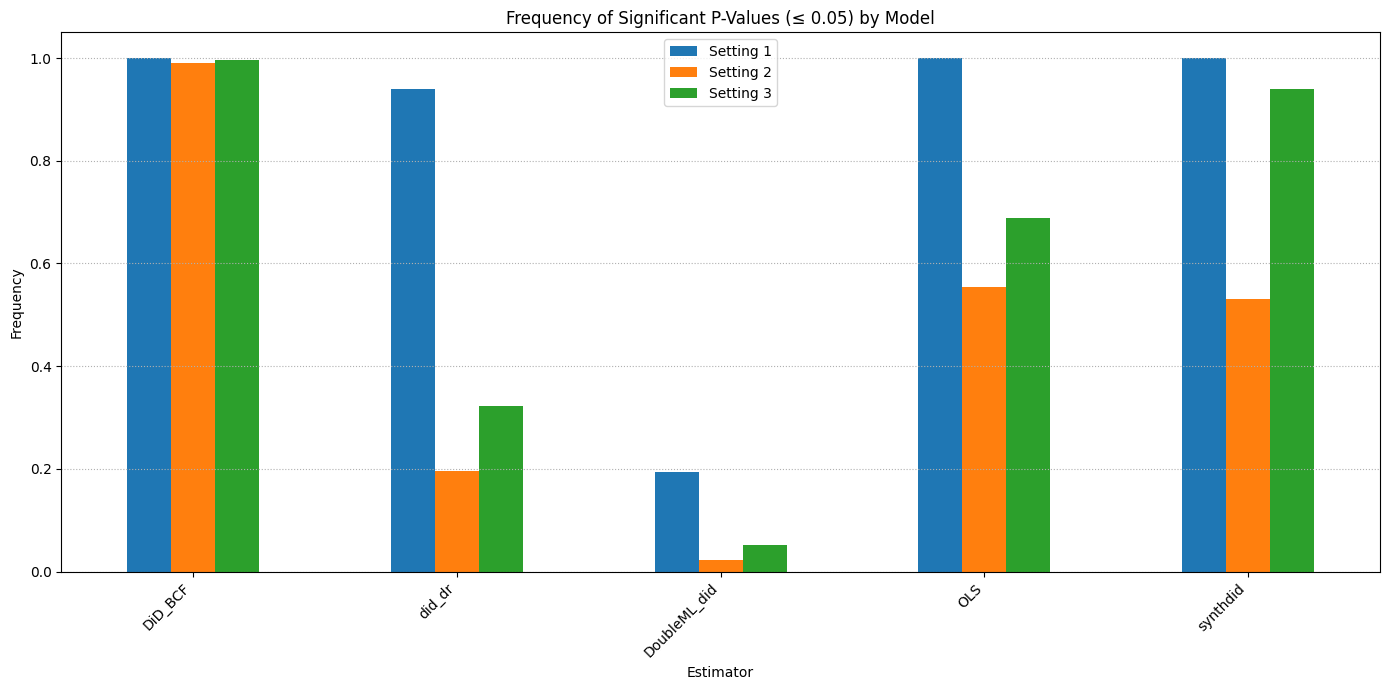

In [5]:
print("Frequency Table (Proportion of P-Values <= 0.05):")
print(frequency_df)
print("\n")

if not frequency_df.empty:
    ax = frequency_df.plot(kind='bar', figsize=(14, 7))
    ax.set_title('Frequency of Significant P-Values (≤ 0.05) by Model')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Estimator')
    plt.xticks(rotation=45, ha='right') # Rotate x-labels for better readability
    plt.legend(title='')
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout() # Adjust layout to make room for labels
    plt.show()
else:
    print("No data to plot.")